In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.model import UnetDecodeNoBn
import shutil
from torch.utils.tensorboard import SummaryWriter
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.engine.gmm_loss import PointProcessGaussian

from decode_fish.funcs.visualization import *
import ipyvolume as ipv

base_path =  '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/'

In [3]:
Path(base_path)

PosixPath('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm')

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [5]:
cfg = OmegaConf.load('config/train.yaml')

In [161]:
cfg.output.project = 'RS_sim'

cfg.run_name ='RS_sim_sig2_1'
cfg.data_path.image_path = base_path + '/datasets/CodFish/RS_fish_sims/Empty Bg Density Range Sigxy 2 SigZ 2/Poiss_300spots_bg_200_2_I_300_0_img0.tif'
cfg.data_path.psf_path = None
cfg.ground_truth = None
cfg.microscope.psf_extent_zyx = [21,21,21]

cfg.bg_estimation.smoothing_filter_size = 10

cfg.foci.n_foci_avg = 0

cfg.evaluation.txt_path = None
cfg.evaluation.crop_sl = 's_[:,200:250,150:200,:]'
cfg.evaluation.px_size =  [100,100,100]

cfg.PSF.gauss_radii = [2.,2.,2.]
cfg.prob_generator.low= 0.0015
cfg.prob_generator.high= 0.0015

cfg.microscope.multipl = 0.15

cfg.noise.theta = .02
cfg.noise.baseline = 0

cfg.supervised.num_iter = 10000
cfg.autoencoder.num_iter = 0

In [162]:
OmegaConf.save(cfg, f'config/experiment/{cfg.run_name}.yaml')

In [16]:
img_3d, decode_dl = get_dataloader(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)

In [143]:
# x, local_rate, background = next(iter(decode_dl))
# sim_vars = PointProcessUniform(local_rate, min_int=decode_dl.min_int).sample()
# xsim = micro(*sim_vars)
# xsim = micro.noise(xsim, background).sample()
# plt.hist(cpu(xsim).reshape(-1))

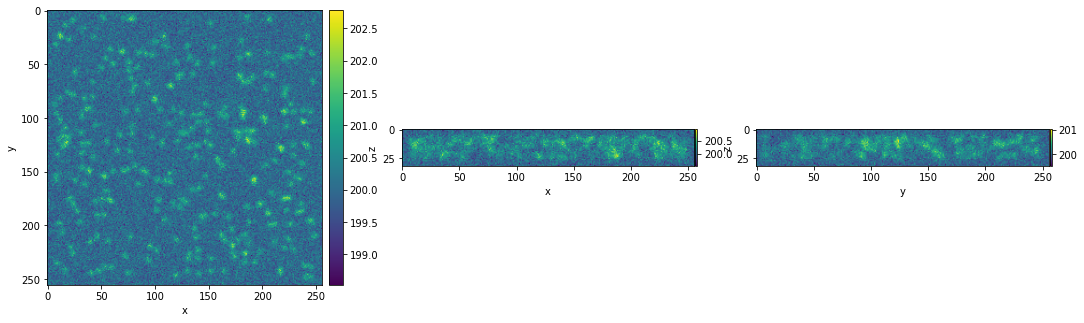

In [159]:
_ = plot_3d_projections(img_3d)

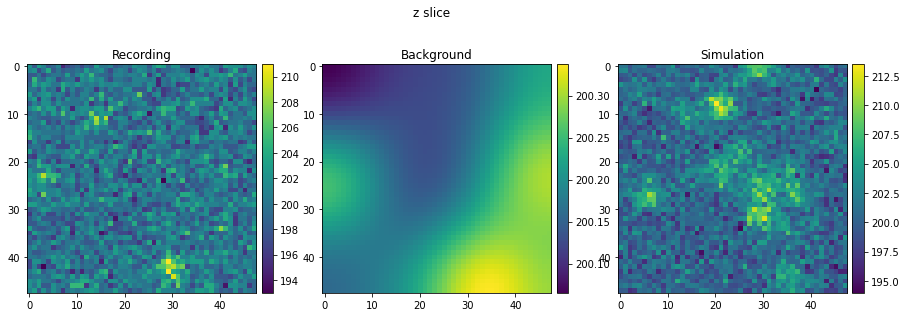

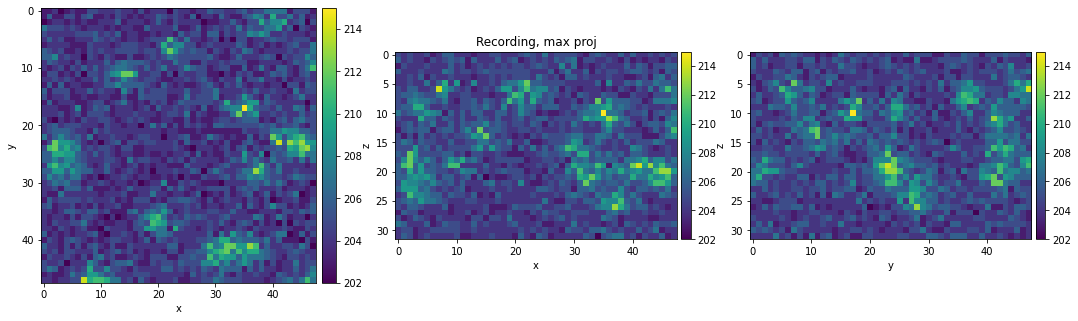

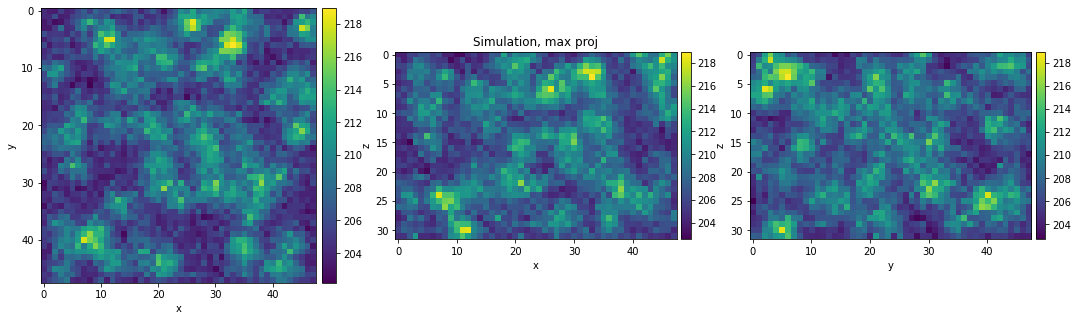

In [145]:
get_simulation_statistics(decode_dl, micro, int_threshold=100)

In [163]:
home_dir = os.getenv("HOME")
f'bsub -gpu "num=1" -q gpu_any -o {home_dir}/logs/ofish.log -e {home_dir}/logs/efish.log {home_dir}/anaconda3/envs/decode2_dev/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name}'

'bsub -gpu "num=1" -q gpu_any -o /groups/turaga/home/speisera/logs/ofish.log -e /groups/turaga/home/speisera/logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode2_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=RS_sim_sig2_1'

In [99]:
def eval_perf(model, post_proc, img, gt, cuda=True, shift=[0,0,0]):
    
    model.eval().cuda() if cuda else model.eval().cpu()
    with torch.no_grad():
        res_dict = model(img[None].cuda()) if cuda else model(img[None])
    pred_df = post_proc(res_dict, 'df')
    free_mem()
    
    pred = shift_df(pred_df, shift)
    perf_df, matches, _ = matching(gt, pred, print_res=True, tolerance=300)
    return pred, perf_df

In [6]:
exp = 'RS_sim_sig2_1'
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/RS_sim/nb_run/{exp}/train.yaml')

In [7]:
path = Path(cfg.output.save_dir)
model = hydra.utils.instantiate(cfg.model)
model = load_model_state(model, path, 'model.pkl')
post_proc = hydra.utils.instantiate(cfg.post_proc_isi, samp_threshold=0.5)
psf, noise, micro = load_psf_noise_micro(cfg)
psf.load_state_dict(torch.load(path/'psf.pkl'))
psf.cuda()

LinearInterpolatedPSF()

In [ ]:
img_3d, decode_dl = get_dataloader(cfg)

In [92]:
print(cfg.data_path.image_path)
gt_df = rsfish_to_df(cfg.data_path.image_path[:-5]+'0.loc')
rs_df = rsfish_to_df(cfg.data_path.image_path[:-5]+'0.loc3')

/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/RS_fish_sims/Empty Bg Density Range Sigxy 2 SigZ 2/Poiss_300spots_bg_200_2_I_300_0_img0.tif


/groups/turaga/home/speisera/anaconda3/envs/decode2_dev/lib/python3.7/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [111]:
def eval_perf(model, post_proc, img, gt, cuda=True, shift=[0,0,0]):
    
    model.eval().cuda() if cuda else model.eval().cpu()
    with torch.no_grad():
        res_dict = model(img[None].cuda()) if cuda else model(img[None])
    pred_df = post_proc(res_dict, 'df')
    free_mem()
    
    pred = shift_df(pred_df, shift)
    perf_df, matches, _ = matching(gt, pred, print_res=True, tolerance=300)
    return pred, perf_df

In [97]:
perf_df, matches, shift = matching(px_to_nm(gt_df), px_to_nm(rs_df), tolerance=300, print_res=True)

Recall: 0.913
Precision: 1.000
Jaccard: 91.333
RMSE_vol: 64.722
Eff_3d: 66.499
FN: 26.0 FP: 0.0
Shift: 2.24,2.48,4.44


In [112]:
pred_df = eval_perf(model, post_proc, img_3d[None], px_to_nm(gt_df), cuda=True, shift=[0,0,50])
free_mem()

Recall: 0.993
Precision: 1.000
Jaccard: 99.333
RMSE_vol: 34.663
Eff_3d: 82.656
FN: 2.0 FP: 0.0
Shift: -0.88,0.35,-6.52


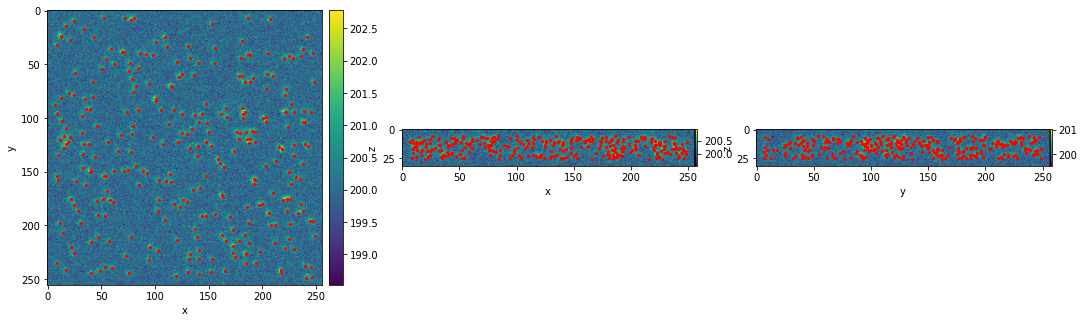

In [51]:
axes = plot_3d_projections(img_3d)
px_preds = nm_to_px(pred_df)
axes[0].scatter(px_preds['x'],px_preds['y'], color='red', s=5.)
axes[1].scatter(px_preds['x'],px_preds['z'], color='red', s=5.)
axes[2].scatter(px_preds['y'],px_preds['z'], color='red', s=5.)

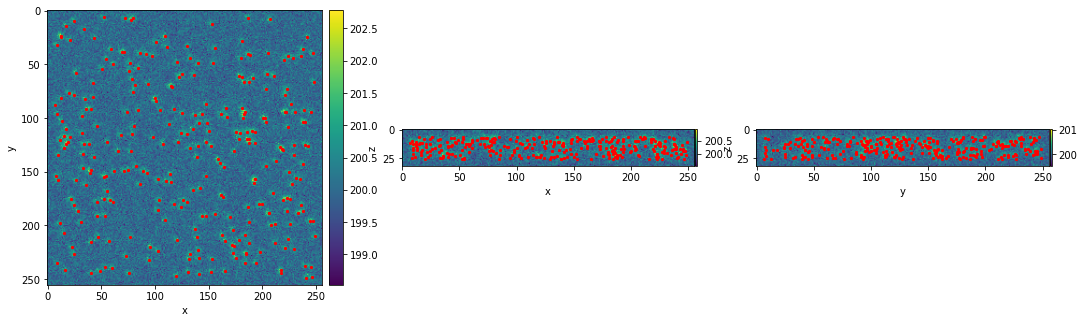

In [199]:
axes = plot_3d_projections(img_3d)
axes[0].scatter(rs_df['x'],rs_df['y'], color='red', s=5.)
axes[1].scatter(rs_df['x'],rs_df['z'], color='red', s=5.)
axes[2].scatter(rs_df['y'],rs_df['z'], color='red', s=5.)